# Using Scanpy to Analyze Single-Cell Ovarian Cancer Data

The goal of this is to study the expression patterns of four DNA mismatch repair genes, MLH1, MSH2, MSH6 and PMS2. Mutations in these genes are known to cause Lynch Syndrome, an autosomal dominantly inherited disorder of cancer susceptibility. We would like to see where each of these mutations are individually expressed, and if there is a link between which gene mutation you have and the type of cancer that one may receive in the future.

## Background Information

Insert some info on each mutation, and about Lynch Syndrome in general. 

## Hypothesis

Mention:
* Mutations in MLH1 is the most common in those who have Lynch Syndrome, why is this? It has low tissue specificity, which means we might expect it to be in many different types of cells
* Stuff about each different gene
* Overall, we are trying to figure out why mutations in each type of gene cause different types of cancers


## Getting Data and Import Statements

First, we need to get our data. For this project, we are analyzing an ovarian cancer single-cell RNA sequencing dataset, GSE146026. This dataset contains 12 ovarian cancer samples from two technologyies (six from 10x and size from smartseq2) that are in the form of RSEM normalized counts. These samples are all from high-grade serous carcinomas. 

They were received from the following site:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE146026

Study that uses this data (as reference): https://www.frontiersin.org/articles/10.3389/fgene.2022.823082/full

Use this link to get the precise data that we will be using (cannot upload to github because too big): https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE146026&format=file&file=GSE146026%5FIzar%5FHGSOC%5Fascites%5F10x%5Flog%2Etsv%2Egz

Once downloaded into this directory, we can access it:

In [3]:
filepath = 'GSE146026_Izar_HGSOC_ascites_10x_log.tsv'

Now, we import necessary packages for data analysis (numpy, pandas, and scanpy):

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

This dataset has * insert info about dataset *

In [5]:
adata = sc.read_csv(filepath, delimiter = '\t', first_column_names=True, dtype=str )   

In [6]:
adata = adata[7:]

In [7]:
adata
print(adata.obs)
print(adata.var)

Empty DataFrameView
Columns: []
Index: [AL627309.1, LINC00115, SAMD11, NOC2L, HES4, ISG15, AGRN, C1orf159, TNFRSF18, TNFRSF4, SDF4, B3GALT6, UBE2J2, ACAP3, PUSL1, CPSF3L, GLTPD1, DVL1, MXRA8, AURKAIP1, CCNL2, RP4-758J18.2, MRPL20, ANKRD65, VWA1, ATAD3B, ATAD3A, SSU72, C1orf233, RP11-345P4.9, MIB2, MMP23B, CDK11B, SLC35E2B, CDK11A, NADK, GNB1, C1orf86, SKI, RER1, PEX10, PANK4, RP3-395M20.12, TNFRSF14, FAM213B, MMEL1, TPRG1L, WRAP73, SMIM1, LRRC47, CEP104, C1orf174, KCNAB2, RPL22, RNF207, ICMT, ACOT7, TNFRSF25, NOL9, ZBTB48, KLHL21, PHF13, THAP3, DNAJC11, CAMTA1, VAMP3, PER3, UTS2, TNFRSF9, PARK7, ERRFI1, RERE, ENO1, SLC2A5, GPR157, RP3-510D11.2, H6PD, SPSB1, SLC25A33, TMEM201, PIK3CD, CLSTN1, CTNNBIP1, LZIC, NMNAT1, RBP7, UBE4B, KIF1B, PGD, APITD1, DFFA, PEX14, TARDBP, SRM, EXOSC10, MTOR, UBIAD1, FBXO2, FBXO44, FBXO6, ...]

[11548 rows x 0 columns]
Empty DataFrameView
Columns: []
Index: [10x_1, 10x_2, 10x_3, 10x_4, 10x_5, 10x_6, 10x_7, 10x_8, 10x_9, 10x_10, 10x_11, 10x_12, 10x_13, 10x_1

In [12]:
adata = adata.copy().transpose()


## Preprocessing

We can show which genes yield the highest fraction of counts in each single cell:

I'm thinking here we can show how we clean the cell data (get rid of ones with barely any genes expression, normalize stuff, get it ready for analysis. Set up the right settings in scanpy so that we can get good results, set up diagram settings so it's nice and pretty. Use methods shown in the tutorials, and explain what each step does and why it is important.

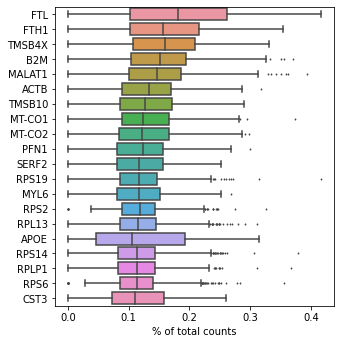

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

Now, we need to filter out the genes that are detected in less than 3 cells:

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

For quality control, we need to assemble information about mitochondrial genes:
* High proportions of mitochondrial genes indicate poor-quality cells

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

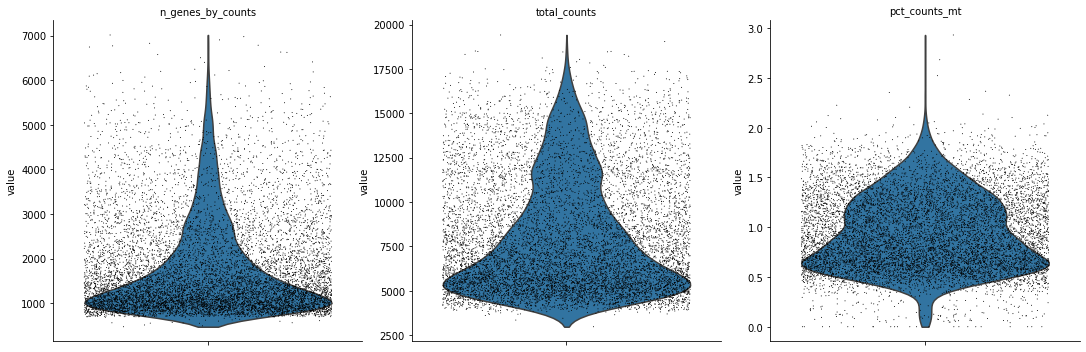

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

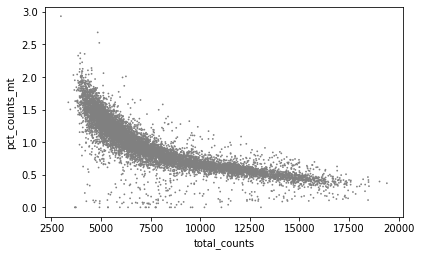

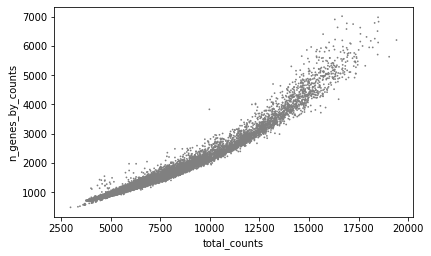

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the AnnData object.

In [19]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

As we are dealing with already normalized data, we are able to compare the read counts per cell. Next, we logarithmize the data:

In [20]:
sc.pp.log1p(adata)

/Users/signehoel/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Identify highly-variable genes:

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

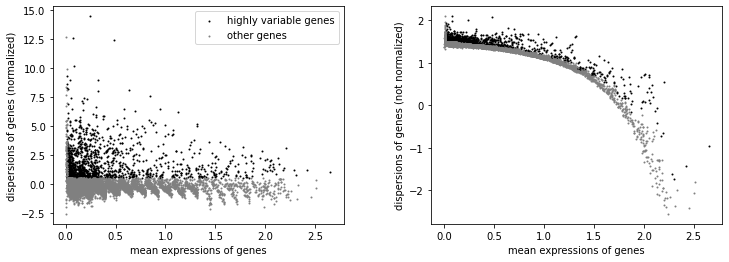

In [22]:
sc.pl.highly_variable_genes(adata)

Note: Think I am doing something wrong but whatever I will go back later

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [23]:
adata.raw = adata

In [24]:
adata = adata[:, adata.var.highly_variable]

In [25]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [26]:
sc.pp.scale(adata, max_value=10)

## Principal Component Analysis

* This is used to reduce the dimensionality of the data, denoising the data and putting it into 2D.

* Look at different clustering functions (louvain, tSNE, etc), explain what they do.

* Check out variance ratio

* We should get *8 clusters* (macrophages, monocytes, smooth muscle cells, epithelial cells, fibroblasts, B cells, NK cells, and DC)

In [27]:
sc.tl.pca(adata, svd_solver='arpack')

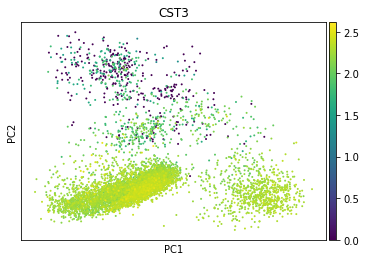

In [28]:
sc.pl.pca(adata, color='CST3')

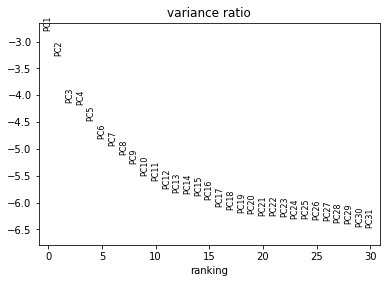

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

In [30]:
adata

AnnData object with n_obs × n_vars = 7586 × 1571
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [113]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:02)


## Embedding the neighborhood graph

In [114]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:11)


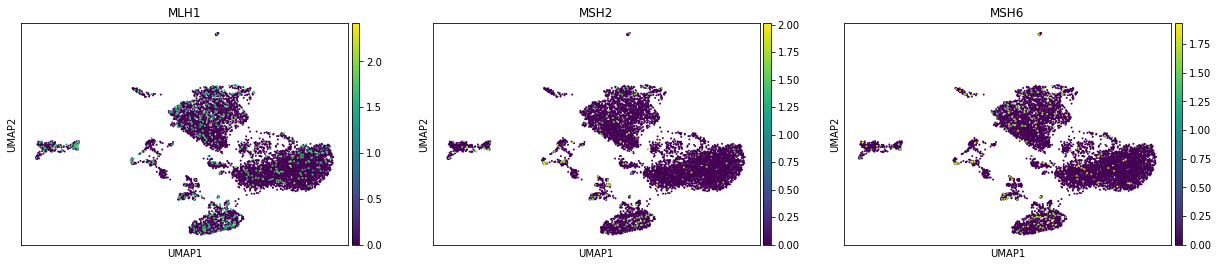

In [115]:
sc.pl.umap(adata, color=['MLH1', 'MSH2', 'MSH6'])

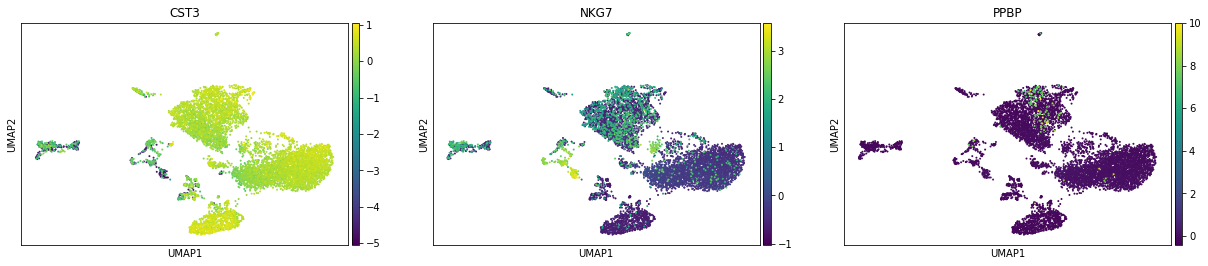

In [116]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering - Leiden

In [117]:
sc.tl.leiden(adata, key_added = "leiden_1.0") # default resolution in 1.0
sc.tl.leiden(adata, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata, resolution = 1.4, key_added = "leiden_1.4")

running Leiden clustering
    finished (0:00:01)
running Leiden clustering
    finished (0:00:01)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:01)


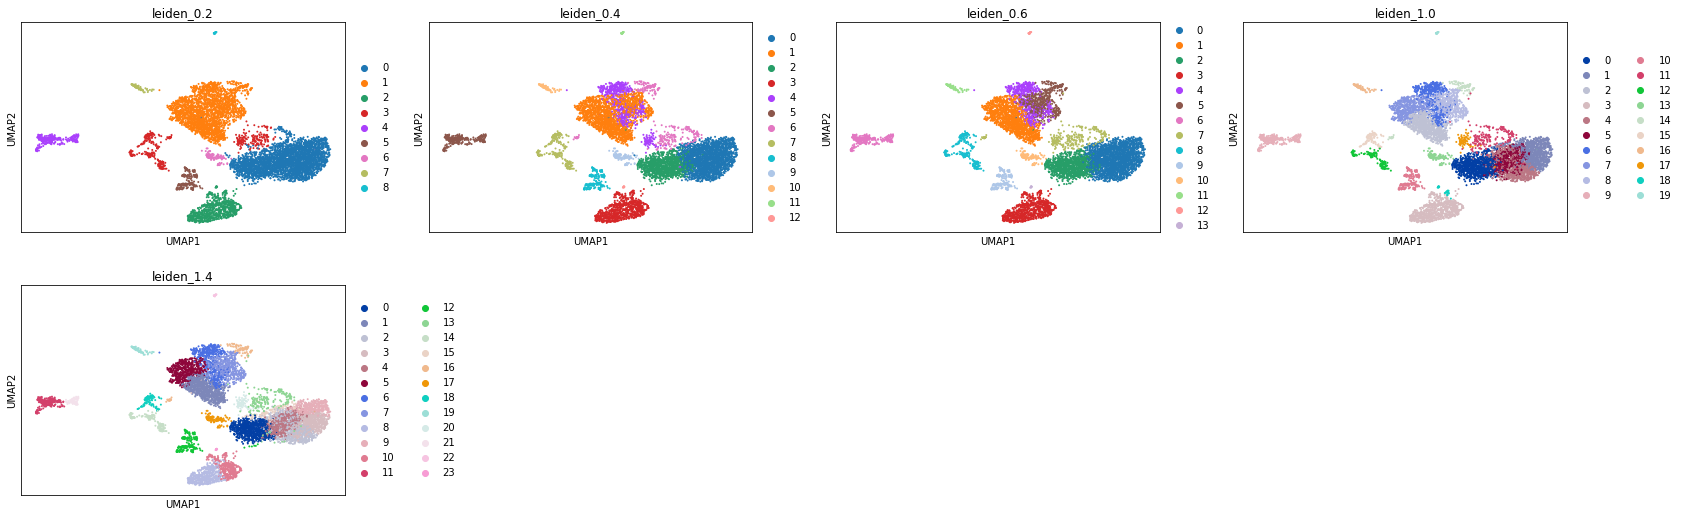

In [118]:
sc.pl.umap(adata, color=['leiden_0.2','leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])

We can see that with increased resolution, we get higher granularity in the clustering. Looking at this graph, we can look further into resolution = 0.4.

We can now look further into the relationships between these clusters:

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_0.2']`


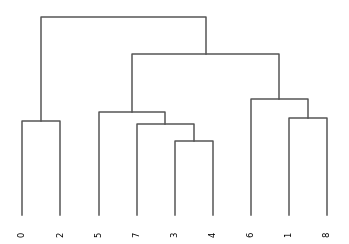

<AxesSubplot:>

In [119]:
sc.tl.dendrogram(adata, groupby = "leiden_0.2")
sc.pl.dendrogram(adata, groupby = "leiden_0.2")


## Clustering - Louvain

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


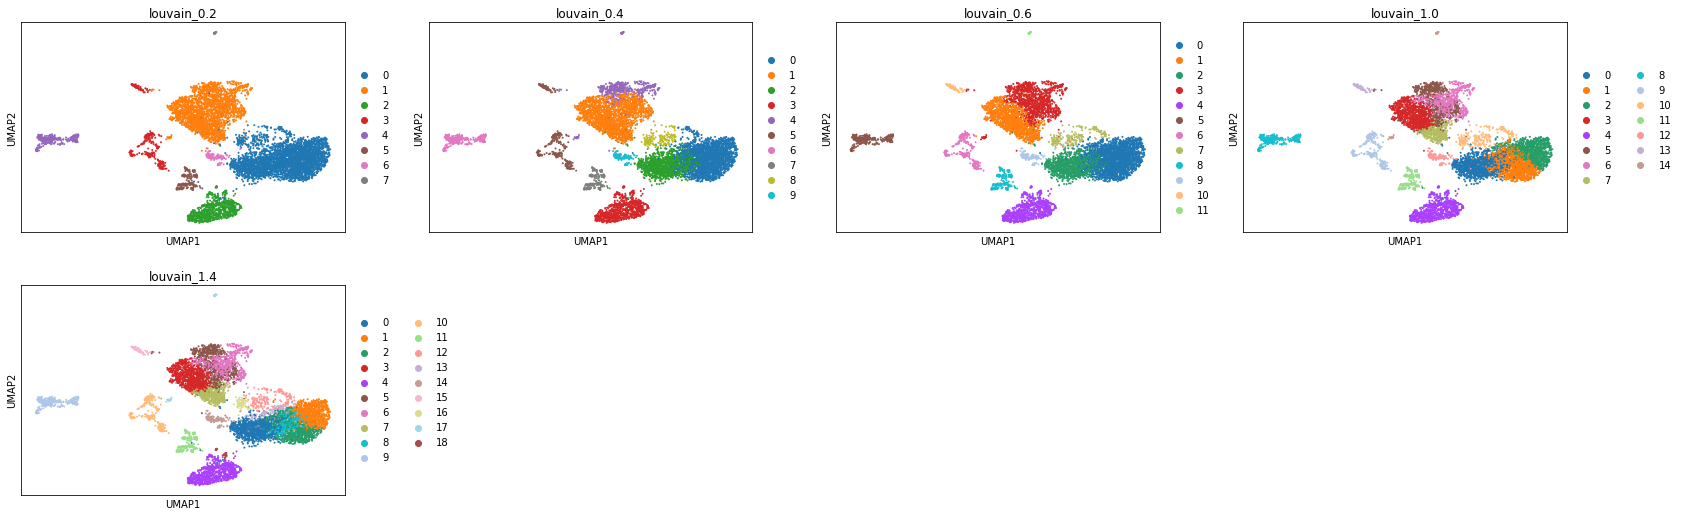

In [124]:
sc.tl.louvain(adata, key_added = "louvain_1.0") # default resolution in 1.0
sc.tl.louvain(adata, resolution = 0.6, key_added = "louvain_0.6")
sc.tl.louvain(adata, resolution = 0.4, key_added = "louvain_0.4")
sc.tl.louvain(adata, resolution = 0.2, key_added = "louvain_0.2")
sc.tl.louvain(adata, resolution = 1.4, key_added = "louvain_1.4")

sc.pl.umap(adata, color=['louvain_0.2', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0','louvain_1.4'])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain_0.2']`


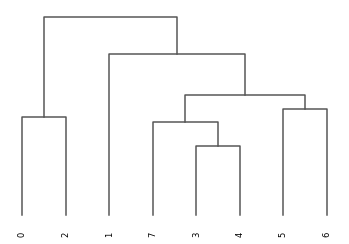

<AxesSubplot:>

In [125]:
sc.tl.dendrogram(adata, groupby = "louvain_0.2")
sc.pl.dendrogram(adata, groupby = "louvain_0.2")

## Finding marker genes

We are going to look at the expression of different genes across the clusters, in order to try and identify what types of cells make up each cluster.

ranking genes
    finished (0:00:07)


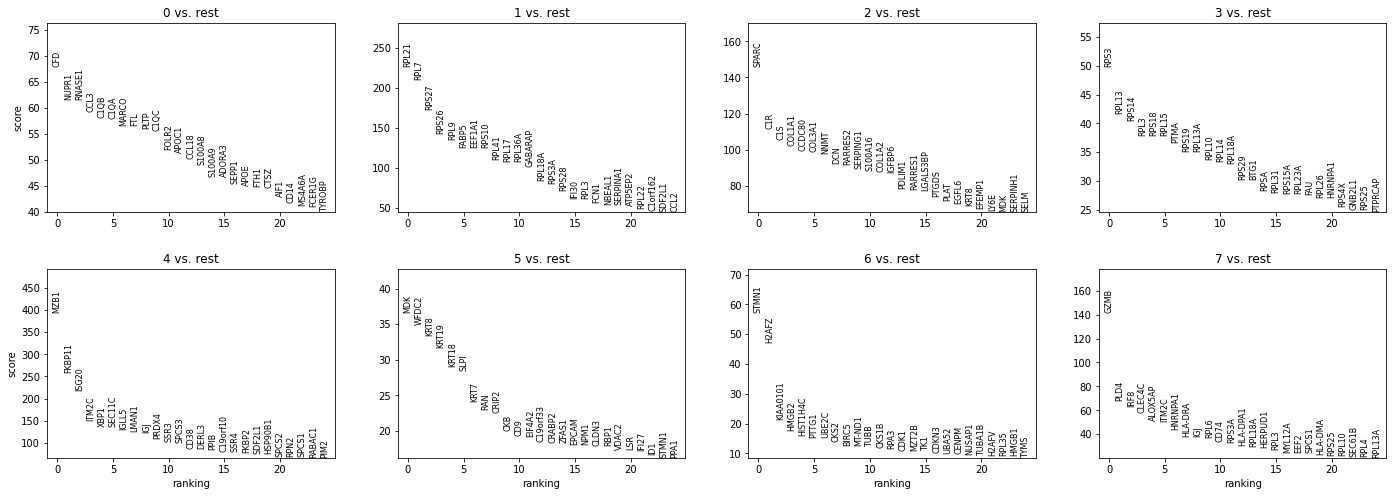

In [126]:
sc.tl.rank_genes_groups(adata, 'louvain_0.2', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [127]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:09)


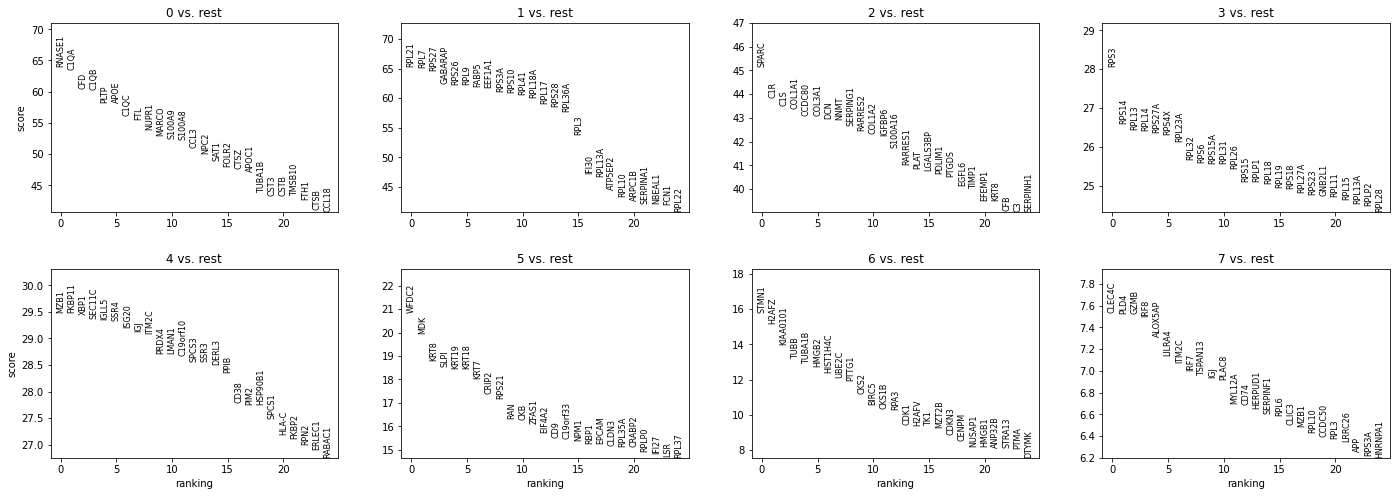

In [130]:
sc.tl.rank_genes_groups(adata, 'louvain_0.2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [131]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RNASE1,RPL21,SPARC,RPS3,MZB1,WFDC2,STMN1,CLEC4C
1,C1QA,RPL7,C1R,RPS14,FKBP11,MDK,H2AFZ,PLD4
2,CFD,RPS27,C1S,RPL13,XBP1,KRT8,KIAA0101,GZMB
3,C1QB,GABARAP,COL1A1,RPL14,SEC11C,SLPI,TUBB,IRF8
4,PLTP,RPS26,CCDC80,RPS27A,IGLL5,KRT19,TUBA1B,ALOX5AP


In [132]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RNASE1,0.0,RPL21,0.0,SPARC,0.0,RPS3,2.379976e-173,MZB1,3.655314e-191,WFDC2,1.201303e-96,STMN1,2.685176e-56,CLEC4C,4.768908e-14
1,C1QA,0.0,RPL7,0.0,C1R,0.0,RPS14,7.152024e-156,FKBP11,4.660880e-191,MDK,1.142354e-88,H2AFZ,4.226702e-52,PLD4,5.306684e-14
2,CFD,0.0,RPS27,0.0,C1S,0.0,RPL13,5.167916e-154,XBP1,1.782396e-190,KRT8,5.473604e-79,KIAA0101,1.779830e-44,GZMB,5.362342e-14
3,C1QB,0.0,GABARAP,0.0,COL1A1,0.0,RPL14,9.137916e-154,SEC11C,1.181996e-189,SLPI,8.864797e-77,TUBB,9.066124e-40,IRF8,6.447514e-14
4,PLTP,0.0,RPS26,0.0,CCDC80,0.0,RPS27A,3.053402e-153,IGLL5,2.355880e-189,KRT19,5.313897e-76,TUBA1B,3.198997e-38,ALOX5AP,2.527951e-13


Using knowledge we can identify markers for certain cell types:

Louvain Group | Markers | Cell Type
---|---|---
0 | C1QA, C1QB | Macrophages
1 | CD14, LYZ | Smooth Muscle Cells
2 | SPARC, COL1A1 |	Cancer Associated Fibroblasts
3 | CD8A |	Epithelial Cells
4 | GNLY, NKG7 | 	NK cells
5 | KRT8, KRT18 |	B cell
6 | GNLY, NKG7 | 	DC
7 | KRT8, KRT18 |	Monocyte

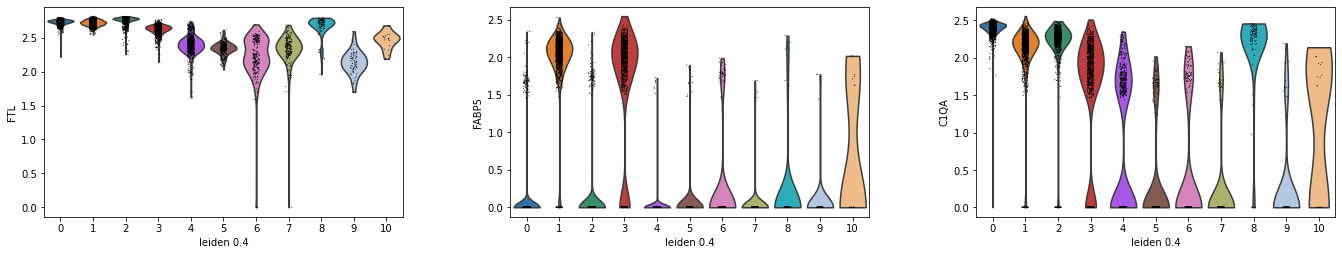

In [100]:
sc.pl.violin(adata, ['FTL', 'FABP5', 'C1QA'], groupby='leiden_0.4')

In [ ]:
new_cluster_names = [
    'Macrophages', '']
adata.rename_categories('leiden', new_cluster_names)

*Edit the above to have marker genes for ovarian cells*

## Gene Expression of Healthy Ovarian Cells

Using healthy ovarian single cell data, we can note the highly expressed genes and compare that to those of the cancer cells.
* Check if DNA Repair Genes are more highly expressed in healthy vs cancer? Because in cancer they are not very expressed



## Expression of Lynch Syndrome genes

Once we have made the graph and clustered based on marker genes (labeling each cluster), we can see how the four DNA repair genes are expressed within these cells. Some questions to consider:

* What type of cells express these genes?
* Which gene is expressed where?
* Is one type of gene expressed in more types of cells? 

## Analysis

We want to look at where our specific genes are expressed (in what type of cells). 